In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Download Data Set

In [2]:
ROOT_DATA_DIR = "content/drive/MyDrive/Datasets/"

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train= True,
    download = True,
    transform = transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train= False, # <<< Test Data
    download = True,
    transform = transforms.ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting content/drive/MyDrive/Datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to content/drive/MyDrive/Datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting content/drive/MyDrive/Datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to content/drive/MyDrive/Datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting content/drive/MyDrive/Datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to content/drive/MyDrive/Datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting content/drive/MyDrive/Datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to content/drive/MyDrive/Datasets/FashionMNIST/raw



In [3]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [4]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [5]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3:' Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
    }

# Visualize Example

In [6]:
def viewImage(data,index,label_map):
  plt.imshow(data.data[index],cmap="gray")
  plt.title(f"Data Label: {label_map[data.targets[index].item()]}")
  plt.axis("off")

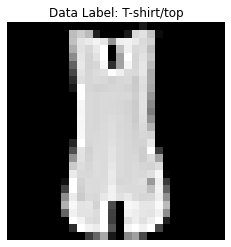

In [7]:
viewImage(train_data,index=4,label_map=label_map)

# Create the DataLoader

In [8]:
BATCH_SIZE = 64

train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle=True
)

In [9]:
for data , label in test_data_loader:
  print(data.shape)
  print(label.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# CNN Architecture


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CNN(nn.Module):
  def __init__(self,in_,out_):
    super(CNN,self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_,out_channels=8,kernel_size=5,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels=8,out_channels=16,kernel_size=5,stride=1,padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features = 16*4*4,out_features = 128)
    self.FC_02 = nn.Linear(in_features = 128,out_features = 64)
    self.FC_03 = nn.Linear(in_features = 64,out_features = out_)

  def forward(self,x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = F.relu(x)
    x = self.FC_02(x)
    x = F.relu(x)
    x = self.FC_03(x)
    return x


In [12]:
model = CNN(1,10)
model.to(device)


CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

# Count no. of Trainable Parameters

In [13]:
def count_parameters(model):
  model_params = {"Modules":list(),"Parameters":list()}
  total = 0
  for name , parameters in model.named_parameters():
    if not parameters.requires_grad:
      continue
    param = parameters.numel()
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total += param
  
  df = pd.DataFrame(model_params)
  df = df.style.set_caption(f"Total Trainabl Parameters: {total}")
  return df


In [14]:
count_parameters(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [15]:
next(model.parameters()).is_cuda

True

# Training Loop


In [16]:
learning_rate = 0.01
num_epochs = 20

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [18]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [19]:
for epoch in range(num_epochs):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images , labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")

      images = images.to(device)
      labels = labels.to(device)

      #forward pass
      output = model(images)
      loss = criterion(output,labels)

      #backkward prop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      tqdm_epoch.set_postfix(loss=loss.item)

Epoch 20/20: 100%|██████████| 938/938 [00:15<00:00, 59.27it/s, loss=<built-in method item of Tensor object at 0x7fa8669df470>]


In [ ]:
os.getcwd()

'/content'

# Save Trained Models

In [ ]:
os.makedirs("Pytorch_Model_dir",exist_ok=True)
model_file = os.path.join("Pytorch_Model_dir","CNN_Model.pth")
torch.save(model,model_file)

In [ ]:
model = torch.load("Pytorch_Model_dir/CNN_Model.pth")

In [ ]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
  for batch,data in enumerate(test_data_loader):
    image , label = data[0].to(device), data[1].to(device)

    y_pred = model(image)

    pred = np.concatenate((pred , torch.argmax(y_pred,1).cpu().numpy()))
    target = np.concatenate((target,label.cpu().numpy()))

In [ ]:
cm = confusion_matrix(target,pred)


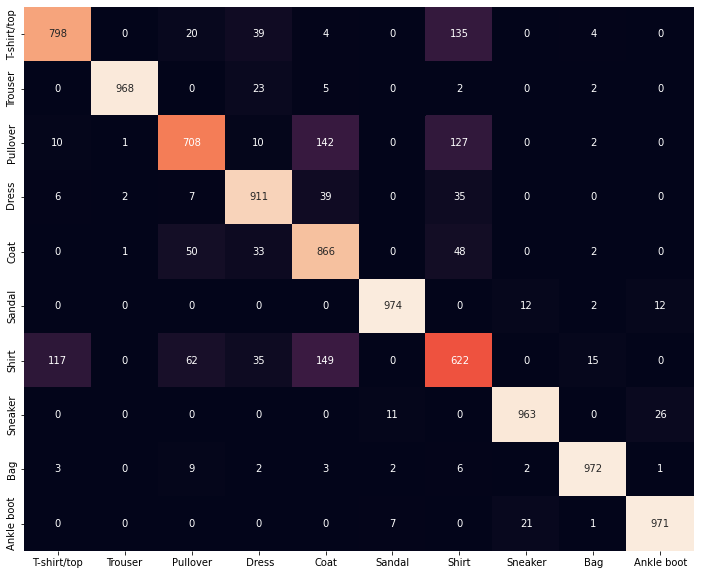

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=label_map.values(),yticklabels=label_map.values(),cbar = False)

# Prediction

In [20]:
data = next(iter(test_data_loader))
data

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [21]:
len(data)

2

In [22]:
images , label = data


In [23]:
images.shape

torch.Size([64, 1, 28, 28])

In [24]:
label.shape

torch.Size([64])

In [26]:
img.shape , img.squeeze().shape , img.unsqueeze(1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [27]:
logit = model(img.unsqueeze(1).to(device))
logit

tensor([[-147.7588,  146.0027, -186.5658,  -95.7871, -200.3948, -177.5272,
         -130.8618, -484.6170, -191.8956, -310.4283]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [28]:
pred_prob = F.softmax(logit,dim=1)
pred_prob

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [29]:
argmax = torch.argmax(pred_prob).item()
argmax

1

In [30]:
label_map[argmax]

'Trouser'